# Restoring Color to Greyscale Images

In [1]:
import image
import os
import random
import numpy as np
import scipy as sp
import time

from sklearn import linear_model
from sklearn import ensemble
from sklearn import naive_bayes

%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from matplotlib import cm
figsize(16, 4)

In [2]:
imdir = "images/raw"
handles = os.listdir(imdir)
random.shuffle(handles)
print "Found {l} image handles".format(l=len(handles))

Found 20560 image handles


## Playing Around with Shallow Regressors

In [3]:
def ShowColorAndGreyscale(color, grey):
    _, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(color)
    ax2.imshow(grey, cmap=cm.gray)
    plt.show()

    
def ShowChannels(color, grey):
    _, axes = plt.subplots(1, 3)
    for ch in xrange(color.shape[2]):
        ax = axes[ch]
        ax.imshow(color[:, :, ch:ch + 1].reshape(
            grey.shape), cmap=cm.gray)
    plt.show()


def GeneratePatches(grey, stride):
    ymax, xmax = grey.shape
    stepmin, stepmax = ((stride - 1) / -2, stride / 2)
    steps = range(stepmin, stepmax + 1)
    trimmed_shape = (ymax - 2 * stepmax, xmax - 2 * stepmax)
    
    # convolutional patches for training
    # there's probably a numpy one-liner for this, but I don't know it
    patches = []
    for xoff in steps:
        for yoff in steps:
            patches.append(
                grey[stepmax + yoff:ymax - stepmax + yoff,
                     stepmax + xoff:xmax - stepmax + xoff])
    patches = np.stack(patches, axis=2)
    plt.imshow(patches.mean(axis=2), cmap=cm.gray)
    plt.show()
    return patches, trimmed_shape, len(steps) ** 2, xmax, ymax, stepmax


def RestoreImageFromFlattenedPatches(ch_clfs, flattened_patches, shape):
    channels = []
    for clf in ch_clfs:
        channels.append(clf.predict(flattened_patches).reshape(
            *shape))
    restored = np.stack(channels, axis=2)
    plt.imshow(restored)
    plt.show()
    return restored


def RestoreImage(ch_clfs, grey, stride):
    patches, trimmed_shape, num_features, _, _, _ = GeneratePatches(
        grey, stride)
    flattened_patches = patches.reshape(
        np.product(trimmed_shape), num_features)
    return RestoreImageFromFlattenedPatches(
        ch_clfs, flattened_patches, trimmed_shape)
    
    
def ModelChannels(color, grey, stride, clf_class, clf_kwargs):
    patches, trimmed_shape, num_features, xmax, ymax, stepmax = GeneratePatches(
        grey, stride)
    flattened_patches = patches.reshape(
        np.product(trimmed_shape), num_features)

    # models for each channel
    ch_clfs = []
    for ch in xrange(color.shape[2]):
        target_luminosities = color[
            stepmax:ymax - stepmax,
            stepmax:xmax - stepmax,
            ch].reshape(np.product(trimmed_shape))
        clf = clf_class(**clf_kwargs)
        clf.fit(flattened_patches, target_luminosities)
        ch_clfs.append(clf)
    
    RestoreImageFromFlattenedPatches(
        ch_clfs, flattened_patches, trimmed_shape)
    
    return ch_clfs


def ProcessImage(color, grey, stride,
                 clf_class=linear_model.LinearRegression, clf_kwargs={}):
    color = image.DownsampledPatch(color, 100, 100)
    grey = image.DownsampledPatch(grey, 100, 100)
    ShowColorAndGreyscale(color, grey)
    ShowChannels(color, grey)
    ch_clfs = ModelChannels(color, grey, stride, clf_class, clf_kwargs)
    return ch_clfs


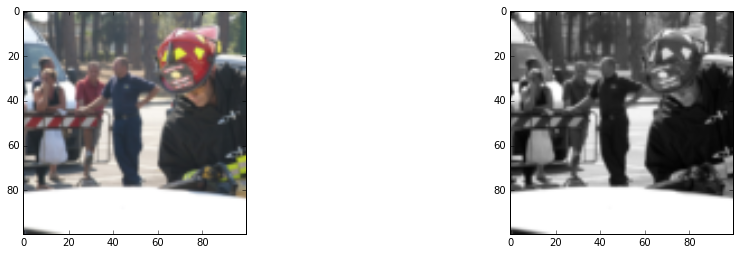

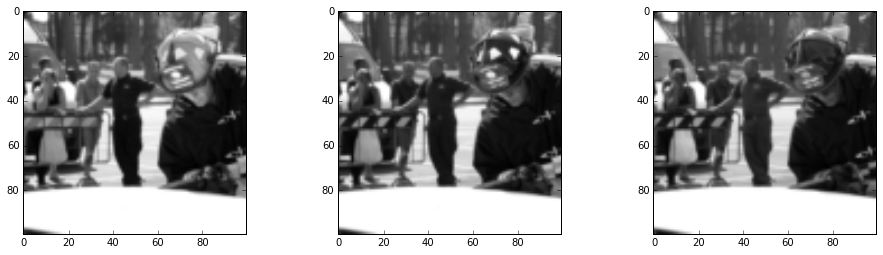

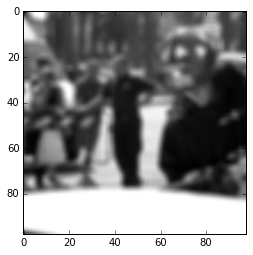

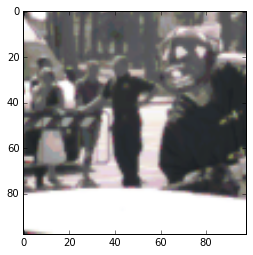

In [4]:
color, grey = image.LoadColorAndGreyscaleImages(
    os.path.join(imdir, handles[random.randint(0, len(handles))]))

ch_clfs = ProcessImage(
    color, grey, 3,
    clf_class=naive_bayes.GaussianNB)